In [1]:
import numpy as np
import random
from platypus import Hypervolume, display, calculate, CMAES, MOEAD, NSGAII, NSGAIII, SPEA2, IBEA, Problem, Real
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

from datetime import datetime

In [2]:
from load_data import *
from bias_functions import *
from utility_functions import *

In [3]:
def getDataset(setSelection):
    if setSelection == 'toy':
        X,y = generate_toy_data(1000,200,2)
    elif setSelection == 'adult':
        protectedAttributes={'race':'White','gender':'Male'}
        X,y = load_adult(protectedAttributes=protectedAttributes)
    elif setSelection == 'bank':
        X,y = load_bank()
    elif setSelection == 'german':
        X,y = load_german()
    elif setSelection == 'mortgage':
        protectedCategoricalAttributes={'applicant_ethnicity_name':'Not Hispanic or Latino',
                                'applicant_race_name_1':'White','applicant_sex_name':'Male'}
        protectedNumericalAttributes=['minority_population']
        X,y = load_mortgage(protectedCategoricalAttributes=protectedCategoricalAttributes, \
                            protectedNumericalAttributes=protectedNumericalAttributes)
    else:
        print('dataset not recognised')
        
    X = np.hstack([X, np.ones((X.shape[0],1))]) ## add ones to solve for affine functions
    
    return X,y

In [4]:
# new problems

# trade offs problem 6: datasets {Adult} and {gender,race} 
# objectives: accuracy, DM across 2 attributes

def problem6_base(w,X,y,sensitiveAttributeIndex1,sensitiveAttributeIndex2):
    errorRateObjective = errorRate(w,X,y)
    fairnessObjective1 = differenceDisparateMistreatment(w,X,y,sensitiveAttributeIndex=sensitiveAttributeIndex1,type='OMR')
    fairnessObjective2 = differenceDisparateMistreatment(w,X,y,sensitiveAttributeIndex=sensitiveAttributeIndex2,type='OMR')
    return errorRateObjective, np.abs(fairnessObjective1[0]-fairnessObjective1[1]),np.abs(fairnessObjective2[0]-fairnessObjective2[1])

def problem6_train(w):
    return problem6_base(w,trainxs,trainys,sensitiveAttributeIndex1=sensitiveAttributeIndex1,sensitiveAttributeIndex2=sensitiveAttributeIndex2)
def problem6_test(w):
    return problem6_base(w,testxs,testys,sensitiveAttributeIndex1=sensitiveAttributeIndex1,sensitiveAttributeIndex2=sensitiveAttributeIndex2)



## Sensitive attributes list:

adult: 8 - race, 9 - gender ;  variables = 15 ; 45222 samples

bank: 0 - age ; variables = 21 ; 41188 samples

german: 6 - gender, 9 - age, 14 - foreign worker ; variables = 25 ; 1000 samples

mortgage: 12 - ethnicity, 14 - race, 16 - gender, 24 - minority population ; variables = 30 ; 200000 samples

In [6]:
now = datetime.now()

# these lines define the problem, test problem, dataset, algorithm and number of sampling runs
noOfObjectives = 3

dataset = 'adult'

if dataset == 'adult':
    sensitiveAttributeIndex1 = 9
    sensitiveAttributeIndex2 = 8
    noOfVariables = 15
elif dataset == 'german':
    sensitiveAttributeIndex1 = 9
    sensitiveAttributeIndex2 = 6
    noOfVariables = 25
else:
    sensitiveAttributeIndex1 = 16
    sensitiveAttributeIndex2 = 14
    noOfVariables = 30

problem = Problem(noOfVariables,noOfObjectives)
problem.function = problem6_train

testProblem = Problem(noOfVariables,noOfObjectives)
testProblem.function = problem6_test



noOfSamplingRuns = 20

X,y = getDataset(dataset)

problem.types[:] = Real(-5,5)

hypervolumeArray = np.zeros((noOfSamplingRuns, 2)) # col 0 for training results (hypervolume), col 1 for test results
extremesArray = np.zeros((2, noOfObjectives, noOfObjectives, noOfSamplingRuns)) # the first dimension is for train/test
averagePointArray = np.zeros((2, noOfSamplingRuns, noOfObjectives)) # the first dimension is for train/test. This array holds the average objective point for each run


# these will be used to store the algorithm that returns the largest hypervolume
bestTrainAlgorithm = None
bestTrainHypervolume = 0
bestTestAlgorithm = None
bestTestHypervolume = 0
totalTrainTime = 0
totalTestTime = 0

for run in range(noOfSamplingRuns):

    # generate new train/test split for each run
    trainxs, testxs, trainys, testys  = train_test_split(X,y,train_size=0.8)  
    
    # training run
    startTime = time.perf_counter()
    
    trainAlgorithm = CMAES(problem)
#     trainAlgorithm = SPEA2(problem,population_size=500)
    trainAlgorithm.run(10000)

    trainHyp = Hypervolume(minimum=[0]*noOfObjectives,maximum=[1]*noOfObjectives)
    trainHypResult = trainHyp(trainAlgorithm.result)  
    hypervolumeArray[run, 0] = trainHypResult
    
    singleRunExtremesArray, averagePoint = findExtremes_averagePoint(trainAlgorithm)
    extremesArray[0,:,:,run] = singleRunExtremesArray
    averagePointArray[0,run,:] = averagePoint
    
    endTime = time.perf_counter()
    trainTime = endTime - startTime
    totalTrainTime += trainTime
    
    print("{}: training took {:.2f} seconds w/ hypervolume {:2f}".format(run, trainTime, trainHypResult))
    
    
    # test run
    testAlgorithm = deepcopy(trainAlgorithm)

    startTime = time.perf_counter()

    for resultNumber, result in enumerate(testAlgorithm.result):

        w=result.variables
        objectivesResult = testProblem.function(w)

        # copy objective results individually to the testAlgorithm object
        for i in range(len(objectivesResult)):  
            testAlgorithm.result[resultNumber].objectives[i]=objectivesResult[i]

    testHyp = Hypervolume(minimum=[0]*noOfObjectives,maximum=[1]*noOfObjectives)
    testHypResult = testHyp(testAlgorithm.result)
    hypervolumeArray[run, 1] = testHypResult
    
    singleRunExtremesArray, averagePoint = findExtremes_averagePoint(testAlgorithm)
    extremesArray[1,:,:,run] = singleRunExtremesArray
    averagePointArray[1,run,:] = averagePoint
        
    
    endTime = time.perf_counter()
    testTime = endTime - startTime
    totalTestTime += testTime

    print("{}: testing took {:.2f} seconds w/ hypervolume {:2f}".format(run, testTime, testHypResult))
    
    if trainHypResult > bestTrainHypervolume:
        bestTrainHypervolume = trainHypResult
        bestTrainAlgorithm = deepcopy(trainAlgorithm)
        
        bestTestHypervolume = testHypResult
        bestTestAlgorithm = deepcopy(testAlgorithm)
        
        bestData = [trainxs, testxs, trainys, testys]
        bestDataSavePath = "saved_data/"+now.strftime("%Y%m%d_%H%M")+"_"+str(problem.function)[10:18]+"_"+dataset+"_"+str(trainAlgorithm)[21:-26]+"_data"
        np.save(bestDataSavePath, bestData)
        
# resultsSummary:
# column 0: average hypervolume, column 1: hypervolume std, column 2: average point std (Euclidean distance), column 3: average time
# row 0: training data, row 1: test data
resultsSummary = np.zeros((2,4)) 
resultsMean = np.sum(hypervolumeArray, axis=0)/noOfSamplingRuns 
resultsSummary[:,0] = resultsMean
resultsSummary[:,1] = np.sqrt(np.sum((hypervolumeArray - resultsMean)**2, axis=0)/noOfSamplingRuns)
averagePointMeans = np.mean(averagePointArray,axis=1)
resultsSummary[0,2] = np.std(np.sqrt(np.sum((averagePointArray[0,:,:]-averagePointMeans[0,:])**2,axis=1)))
resultsSummary[1,2] = np.std(np.sqrt(np.sum((averagePointArray[1,:,:]-averagePointMeans[1,:])**2,axis=1)))
resultsSummary[0,3] = totalTrainTime/noOfSamplingRuns
resultsSummary[1,3] = totalTestTime/noOfSamplingRuns
print(resultsSummary) 

training: 32561
testing: 16281
(45222, 15)
(45222, 14)
race: 8
gender: 9
The dataset is loaded...
0: training took 39.95 seconds w/ hypervolume 0.832387
0: testing took 1.39 seconds w/ hypervolume 0.831697


/Users/nigelkingsman/opt/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


1: training took 43.52 seconds w/ hypervolume 0.833497
1: testing took 1.61 seconds w/ hypervolume 0.828537
2: training took 47.59 seconds w/ hypervolume 0.834813
2: testing took 4.29 seconds w/ hypervolume 0.831040
3: training took 39.97 seconds w/ hypervolume 0.833266
3: testing took 0.94 seconds w/ hypervolume 0.830738
4: training took 48.64 seconds w/ hypervolume 0.833017
4: testing took 4.78 seconds w/ hypervolume 0.832882
5: training took 41.30 seconds w/ hypervolume 0.833510
5: testing took 0.96 seconds w/ hypervolume 0.834258
6: training took 47.89 seconds w/ hypervolume 0.836048
6: testing took 2.22 seconds w/ hypervolume 0.827945
7: training took 41.92 seconds w/ hypervolume 0.832712
7: testing took 1.63 seconds w/ hypervolume 0.828701
8: training took 45.65 seconds w/ hypervolume 0.835512
8: testing took 3.16 seconds w/ hypervolume 0.821532
9: training took 45.72 seconds w/ hypervolume 0.832363
9: testing took 1.96 seconds w/ hypervolume 0.828418
10: training took 42.50 seco

In [19]:
resultsMinMax(bestTrainAlgorithm)[:3]

array([[1.61317964e-01, 4.76372903e-05, 2.09622349e-06],
       [4.30688006e-01, 1.20033074e-01, 5.19602605e-02],
       [1.83116832e-01, 5.97231383e-02, 1.56652159e-02]])

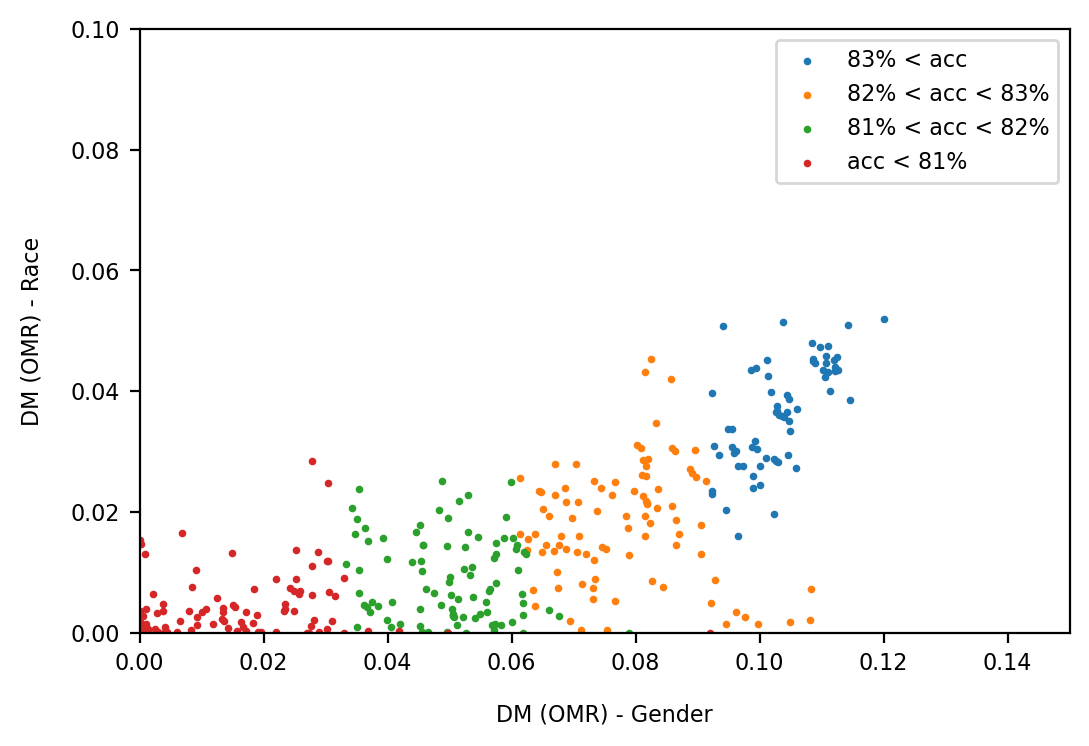

In [33]:
# 2-D chart subject to filter

# %matplotlib qt
%matplotlib inline

import matplotlib.pyplot as plt


now = datetime.now()

axisToFilter = 0
filterMarkers = [0,0.17,0.18,0.19,1]

resultsDict = {}
resultsToUse = np.array([s.objectives[axisToFilter] for s in bestTrainAlgorithm.result])
labelNames = []

for i in range(len(filterMarkers)-1):
    resultsDict[i] = (resultsToUse>filterMarkers[i]) * (resultsToUse<=filterMarkers[i+1])
    if filterMarkers[i] == 0:
        labelName = '{:,.0%} < acc'.format(1-filterMarkers[i+1])
    elif filterMarkers[i+1] == 1:
        labelName = 'acc < {:,.0%}'.format(1-filterMarkers[i])
    else:
        labelName = '{:,.0%} < acc < {:,.0%}'.format(1-filterMarkers[i+1],1-filterMarkers[i])
    labelNames.append(labelName)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)

for i in range(len(filterMarkers)-1):
    ax.scatter(np.array([s.objectives[1] for s in bestTrainAlgorithm.result])[resultsDict[i]],
           np.array([s.objectives[2] for s in bestTrainAlgorithm.result])[resultsDict[i]],s=3)
ax.set_xlabel("DM (OMR) - Gender",labelpad=10,size=8)
ax.set_ylabel("DM (OMR) - Race",labelpad=10,size=8)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_xlim([0,0.15])
ax.set_ylim([0,0.1])
ax.legend(labelNames,fontsize=8) 

# plt.savefig("saved_graphs/"+now.strftime("%Y%m%d_%H%M")+"_"+dataset+"_"+str(bestTrainAlgorithm)[21:-26]+"_axis"+str(axisToFilter)+"_overall",bbox_inches = 'tight')

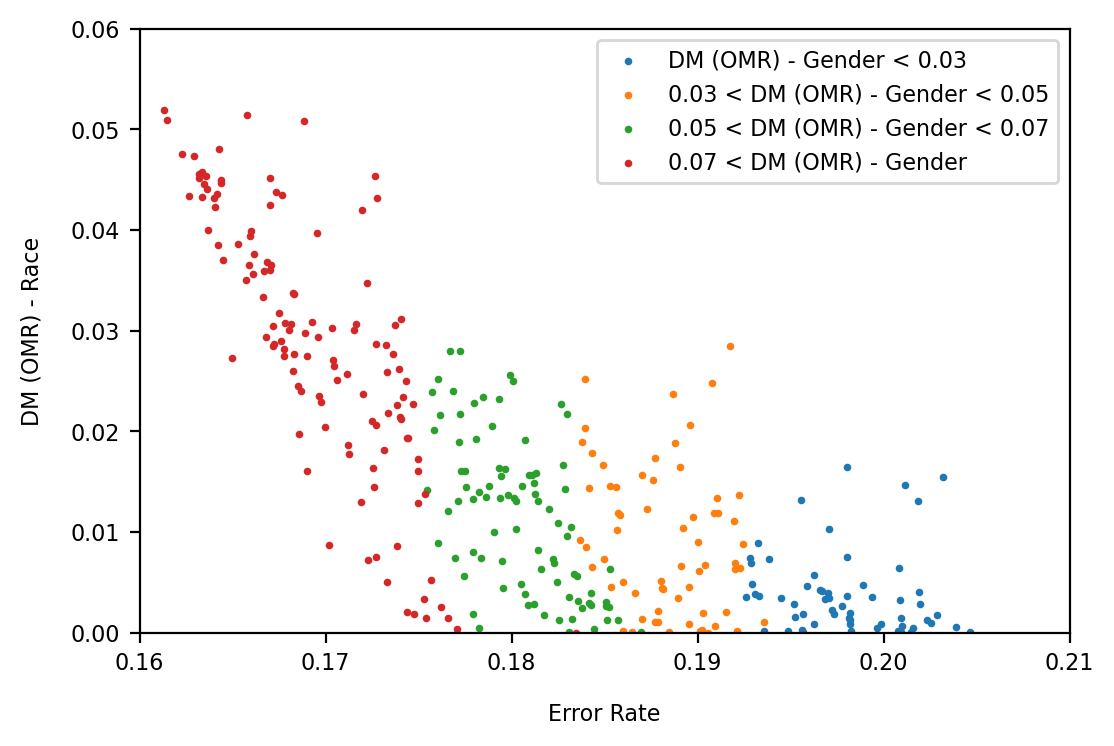

In [48]:
# 2-D chart subject to filter

# %matplotlib qt
%matplotlib inline

import matplotlib.pyplot as plt


now = datetime.now()

axisToFilter = 1
filterMarkers = [0,0.025,0.05,0.075,1]

resultsDict = {}
resultsToUse = np.array([s.objectives[axisToFilter] for s in bestTrainAlgorithm.result])
labelNames = []

for i in range(len(filterMarkers)-1):
    resultsDict[i] = (resultsToUse>=filterMarkers[i]) * (resultsToUse<filterMarkers[i+1])
    if filterMarkers[i] == 0:
        labelName = 'DM (OMR) - Gender < {:,.2f}'.format(filterMarkers[i+1])
    elif filterMarkers[i+1] == 1:
        labelName = '{:,.2f} < DM (OMR) - Gender'.format(filterMarkers[i])
    else:
        labelName = '{:,.2f} < DM (OMR) - Gender < {:,.2f}'.format(filterMarkers[i],filterMarkers[i+1])
    labelNames.append(labelName)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)

for i in range(len(filterMarkers)-1):
    ax.scatter(np.array([s.objectives[0] for s in bestTrainAlgorithm.result])[resultsDict[i]],
           np.array([s.objectives[2] for s in bestTrainAlgorithm.result])[resultsDict[i]],s=3)
ax.set_xlabel("Error Rate",labelpad=10,size=8)
ax.set_ylabel("DM (OMR) - Race",labelpad=10,size=8)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_xlim([0.16,0.21])
ax.set_ylim([0,0.06])
ax.legend(labelNames,fontsize=8) 

plt.savefig("saved_graphs/"+now.strftime("%Y%m%d_%H%M")+"_"+dataset+"_"+str(bestTrainAlgorithm)[21:-26]+"_axis"+str(axisToFilter)+"_overall",bbox_inches = 'tight')

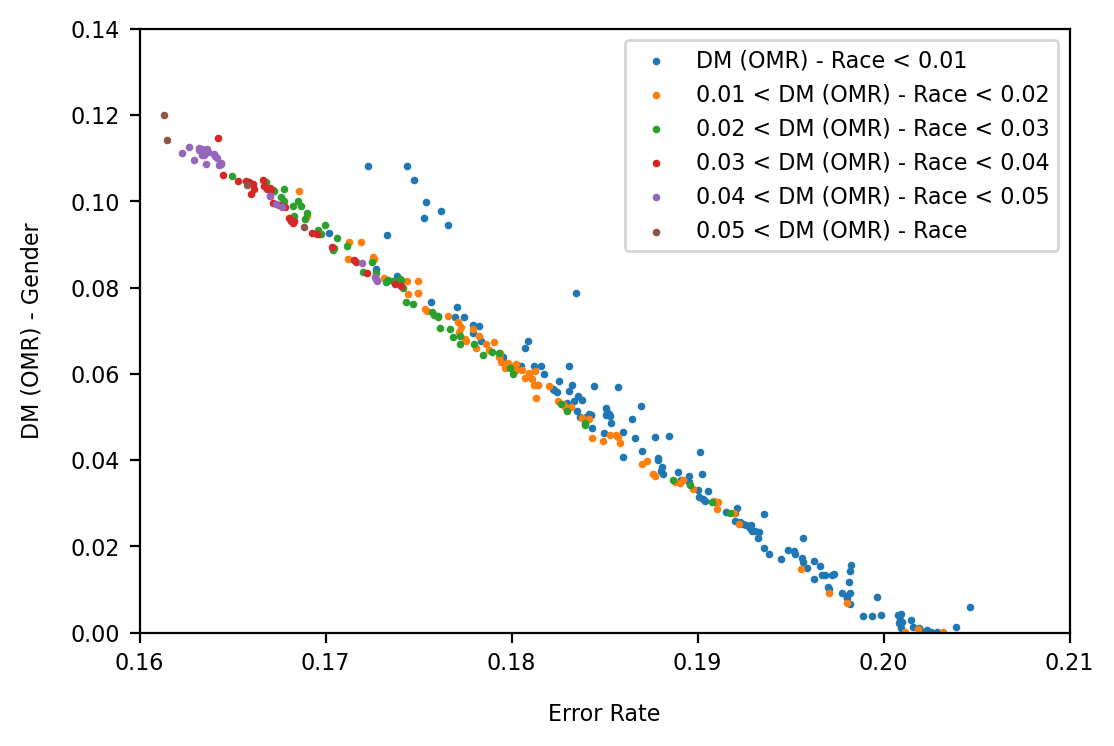

In [49]:
# 2-D chart subject to filter

# %matplotlib qt
%matplotlib inline

import matplotlib.pyplot as plt


now = datetime.now()

axisToFilter = 2
filterMarkers = [0,0.01,0.02,0.03,0.04,0.05,1]

resultsDict = {}
resultsToUse = np.array([s.objectives[axisToFilter] for s in bestTrainAlgorithm.result])
labelNames = []

for i in range(len(filterMarkers)-1):
    resultsDict[i] = (resultsToUse>=filterMarkers[i]) * (resultsToUse<filterMarkers[i+1])
    if filterMarkers[i] == 0:
        labelName = 'DM (OMR) - Race < {:,.2f}'.format(filterMarkers[i+1])
    elif filterMarkers[i+1] == 1:
        labelName = '{:,.2f} < DM (OMR) - Race'.format(filterMarkers[i])
    else:
        labelName = '{:,.2f} < DM (OMR) - Race < {:,.2f}'.format(filterMarkers[i],filterMarkers[i+1])
    labelNames.append(labelName)
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)

for i in range(len(filterMarkers)-1):
    ax.scatter(np.array([s.objectives[0] for s in bestTrainAlgorithm.result])[resultsDict[i]],
           np.array([s.objectives[1] for s in bestTrainAlgorithm.result])[resultsDict[i]],s=3)
ax.set_xlabel("Error Rate",labelpad=10,size=8)
ax.set_ylabel("DM (OMR) - Gender",labelpad=10,size=8)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_xlim([0.16,0.21])
ax.set_ylim([0,0.14])
ax.legend(labelNames,fontsize=8) 

plt.savefig("saved_graphs/"+now.strftime("%Y%m%d_%H%M")+"_"+dataset+"_"+str(bestTrainAlgorithm)[21:-26]+"_axis"+str(axisToFilter)+"_overall",bbox_inches = 'tight')